In [ ]:
import pandas as pd
import os
import pickle

In [ ]:
#Download the initial test statistics
df = pd.read_csv('Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)


In [ ]:
os.getcwd()

In [ ]:
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
#path = os.getcwd() + '\\Data\\permutation_test_files_proteomics'

In [ ]:
#Code to read all files that start with 'Run' in a folder

final_list = []

for filename in os.listdir(path): #also lists directories
    print(filename)
    if filename.startswith('Run'):
        file_num = int(filename[3:-4])  #obtain the number of the Run
        if file_num < 11:
            print(filename)
            with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

In [ ]:
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
print(os.getcwd())

In [ ]:
#Code to read all files in folder that start with 'Results'
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
final_list = []

for filename in os.listdir(path): #also lists directories
    if filename.startswith('Results'):
        print(filename)
        #for file in os.listdir(path + '\\' + filename): 
        for file in os.listdir(os.path.join(path,filename)):
            print(file)
            with open(os.path.join(path, filename,file), 'rb') as file: # open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

In [ ]:
#In a folder with directories list (Results1, Results2, Results3 etc) go through each as a separate array job

#index_num = sys.argv[1]  #this should return the array number within the array job
index_num = 1 #for example
path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics\\Results' + str(index_num)
final_list = []

for filename in os.listdir(path): #also lists directories
    print(filename)
    with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
        list1 = pickle.load(file)
    final_list.append(list1)

In [ ]:
len(final_list)

for list1 in final_list:
    print(len(list1))
    print(list1[:1])

Calculates number of permuted values above the initial test statistic, then divides by number of tests and works out p-value, before outputting the significant edges

In [ ]:
sig_edges = []
edgelist = df.index

for index,pathway_pair in enumerate(edgelist):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    counter = 0
    
    for list1 in final_list:  #len(final_list) = number of permutations
        if abs(list1[index]) >= comparison:   
            counter += 1
    
    p_val = (counter/len(final_list))    #divide number of tests above or equal to the test statistic by total number of tests

    if p_val < 0.01:  #for 100,000 permutations
        sig_edges.append(pathway_pair)  
        
print(len(sig_edges))
sig_edges

Calculates number of permuted values above the initial test statistic (more scalable)

In [ ]:
num_vals = []  #number of permuted values above the magnitude of the test statistic
#sig_edges = []
edgelist = df.index

for index in range(len(edgelist)):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    counter = 0
    
    for list1 in final_list:  #len(final_list) = number of permutations
        if abs(list1[index]) >= comparison:   
            counter += 1
    num_vals.append(counter)

num_vals

### Another alternative: (but converting to numpy array actually seems to take up more memory)

In [ ]:
import numpy as np

final_matrix = np.empty((0,len(df)), int)

for filename in os.listdir(path):
    if filename != 'initial_tstats.csv':
        with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
            list1 = pickle.load(file)
        final_matrix = np.append(final_matrix, np.array([list1]), axis=0)

In [ ]:
final_matrix.shape

In [ ]:
final_matrix = np.array(final_list) 

final_matrix.shape

sig_edges = []
edgelist = df.index

for index,pathway_pair in enumerate(edgelist):   #test all pathways
    comparison = df.Initial_tstat[index]    #get initial test statistic
    counter = 0
    
    col = abs(final_matrix[:,index])  #index a column and turn into absolute values
    counter = (col >= comparison).sum()

    
    p_val = (counter/len(final_list))    #divide number of tests above or equal to the test statistic by total number of tests

    if p_val < 0.01:  #for 100,000 permutations
        sig_edges.append(pathway_pair)  
        
print(len(sig_edges))

In [ ]:
#comparing the size of the object from the first method vs second method
from sys import getsizeof
print(getsizeof(final_list))
print(getsizeof(final_matrix))

In [ ]:
with open ('Data/permutation_test_files_metabolomics/vals_test.txt', 'w') as file:
     file.write(','.join(str(i) for i in num_vals))

### Read in HPC results for the metabolomic data

In [ ]:
import os
import numpy as np 
import statsmodels.stats.multitest
import pandas as pd
from itertools import compress

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Read a file which has the number of values (made absolute in the HPC script) above the initial test statistic

with open('Data/permutation_test_files_metabolomics/vals.txt') as file:
    lines = file.readlines()
    vals = lines[0].split(';')
    vals =  [int(x) for x in vals]
    val_array = np.array(vals)

In [ ]:
pval_array = val_array / 100000
pval_array[:20]

print(len(pval_array)) #10296 values
(pval_array < 0.05).sum()  #795 values

In [ ]:
pval_array[:100]

In [ ]:

sns.histplot(pval_array, bins = 50,color='#B8CDF8',edgecolor="k") 
plt.title('Metabolomic unadjusted p-value distribution',fontsize=16)
plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/unadjusted_pval_metabolomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


In [ ]:
sig_edge_boolean,adjusted_pval = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.05, method='poscorr', is_sorted=False)
sig_edge_boolean

In [ ]:
sig_edge_boolean2,adjusted_pval2 = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.05, method='indep', is_sorted=False)
sig_edge_boolean2

In [ ]:
print(adjusted_pval)
print(adjusted_pval2)

In [ ]:
np.array_equiv(sig_edge_boolean,sig_edge_boolean2)

In [ ]:
sum(sig_edge_boolean) #10 edges significant with method=indep and method=poscorr

In [ ]:

sns.histplot(adjusted_pval, bins = 50,color='#B8CDF8',edgecolor="k") 
plt.title('Metabolomic adjusted p-value distribution',fontsize=16)
plt.xlabel('Adjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/adjusted_pval_metabolomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


Easier to obtain the reverse (i.e. edges that are not significant), since then they can be removed easily

In [ ]:
not_sig_edge_boolean = [not elem for elem in sig_edge_boolean]
sum(not_sig_edge_boolean )

In [ ]:
#Load dataset
df = pd.read_csv('Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
edgelist = df.index


sig_edges = list(compress(edgelist,sig_edge_boolean))
not_sig_edges = list(compress(edgelist,not_sig_edge_boolean))

In [ ]:
with open ('Data/permutation_test_files_metabolomics/not_sig_edges.txt', 'w') as file:
     file.write(','.join(str(i) for i in not_sig_edges))

In [ ]:
#Save number of significant edges BEFORE FDR CORRECTION

sig_edges_beforefdr = list(compress(edgelist,pval_array < 0.05))
print(len(sig_edges_beforefdr))

with open ('Data/permutation_test_files_metabolomics/sig_edges_beforefdr.txt', 'w') as file:
     file.write(','.join(str(i) for i in sig_edges_beforefdr))

### Read in HPC results for the proteomic data

In [1]:
import os 
import numpy as np 
import statsmodels.stats.multitest
import pandas as pd
from itertools import compress

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read ten files that have the number of edges that are of a higher value that the initial test statistic


path = os.getcwd() + '\\Data\\permutation_test_files_proteomics\\Values'
val_array = []


for filename in os.listdir(path): #also lists directories
    with open(os.path.join(path, filename)) as file:    
        lines = file.readlines()
        vals = lines[0].split(';')
        vals =  [int(x) for x in vals]
        print(vals)
        if filename == 'vals1.txt':
            val_array = np.array(vals)
        else:
            val_array = np.vstack([val_array, vals])

[1239, 126, 576, 2479, 8091, 2333, 2479, 8091, 2333, 10000, 41, 458, 267, 1784, 1784, 5, 66, 508, 760, 760, 2932, 29, 346, 354, 6732, 6732, 6455, 305, 126, 576, 10000, 2333, 2333, 267, 508, 354, 11, 114, 485, 2863, 2863, 2073, 1020, 1589, 485, 5715, 6046, 2701, 1236, 1236, 1318, 4578, 1850, 2701, 1638, 1218, 168, 151, 2448, 2448, 10, 0, 3, 151, 2, 8819, 92, 20, 364, 1889, 1889, 0, 3, 1, 364, 0, 7341, 1878, 91, 237, 1280, 4802, 4802, 116, 2499, 287, 1280, 556, 5748, 751, 503, 91, 237, 1280, 4802, 4802, 116, 2499, 287, 1280, 556, 5748, 751, 503, 10000, 1312, 1406, 624, 1533, 1533, 6467, 3704, 1582, 624, 2198, 9634, 1796, 1836, 8177, 8177, 13, 80, 455, 3643, 3643, 234, 399, 415, 455, 724, 1853, 38, 30, 993, 993, 1057, 2594, 1306, 1559, 8139, 8139, 215, 2, 6, 1559, 11, 6798, 418, 36, 260, 260, 1040, 968, 651, 132, 1470, 9180, 9180, 257, 8, 29, 1470, 13, 6987, 246, 24, 424, 424, 948, 3908, 464, 3589, 5335, 1819, 9087, 9087, 8709, 8849, 5356, 1819, 4450, 7683, 2901, 3187, 9317, 9317, 4593, 6

In [3]:
val_array
val_array2 = val_array.sum(axis=0)
pval_array = val_array2 / 100000
pval_array[:20]

print(len(pval_array)) #166753 values
(pval_array < 0.05).sum() #56256 values

166753


56256

Text(0, 0.5, 'Count')

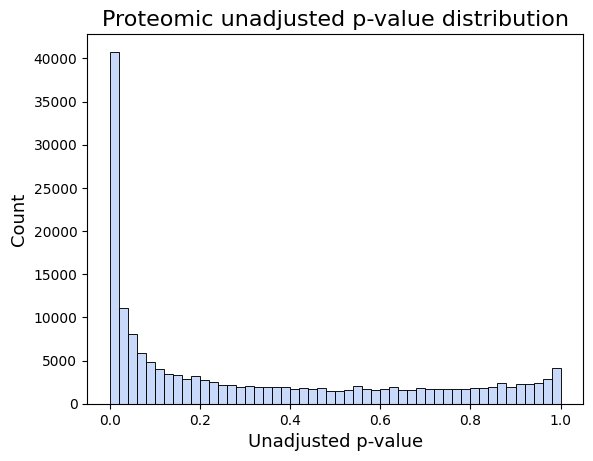

In [4]:
sns.histplot(pval_array, bins = 50,color='#B8CDF8',edgecolor="k") 
plt.title('Proteomic unadjusted p-value distribution',fontsize=16)
plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/unadjusted_pval_proteomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


In [5]:
sig_edge_boolean,adjusted_pval = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.05, method='poscorr', is_sorted=False)
sig_edge_boolean

array([False, False, False, ..., False, False, False])

In [6]:
sig_edge_boolean2,adjusted_pval2 = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.05, method='indep', is_sorted=False)
sig_edge_boolean2

array([False, False, False, ..., False, False, False])

In [7]:
print(adjusted_pval)
print(adjusted_pval2)

[0.26760044 0.06828059 0.166424   ... 0.87413652 0.68610593 0.85608649]
[0.26760044 0.06828059 0.166424   ... 0.87413652 0.68610593 0.85608649]


In [8]:
sig_edge_boolean == sig_edge_boolean2
np.array_equiv(sig_edge_boolean,sig_edge_boolean2)

True

In [9]:
adjusted_pval

array([0.26760044, 0.06828059, 0.166424  , ..., 0.87413652, 0.68610593,
       0.85608649])

In [10]:
sum(sig_edge_boolean) #29327 edges significant with method=indep and method=poscorr

29327

In [ ]:
sns.histplot(adjusted_pval, bins = 50,color='#B8CDF8',edgecolor="k") 
plt.title('Proteomic adjusted p-value distribution',fontsize=16)
plt.xlabel('Adjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/adjusted_pval_proteomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


Easier to obtain the reverse (i.e. edges that are not significant), since then they can be removed easily

In [11]:
not_sig_edge_boolean = [not elem for elem in sig_edge_boolean]
sum(not_sig_edge_boolean )

137426

In [12]:
#Load dataset
df = pd.read_csv('Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)
edgelist = df.index


sig_edges = list(compress(edgelist,sig_edge_boolean))
not_sig_edges = list(compress(edgelist,not_sig_edge_boolean))

In [13]:
#with open ('Data/permutation_test_files_proteomics/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
with open ('Data/permutation_test_files_proteomics/not_sig_edges.txt', 'w') as file:
     file.write(','.join(str(i) for i in not_sig_edges))

### Plotting the test statistic distribution for randomly chosen pathway pairs - Metabolomic data


In [ ]:
import pandas as pd
import os
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Download the initial test statistics
df = pd.read_csv('Data/permutation_test_files_metabolomics/initial_tstats.csv', index_col=0)
#df = pd.read_csv('Data/permutation_test_files_proteomics/initial_tstats.csv', index_col=0)

path = os.getcwd() + '\\Data\\permutation_test_files_metabolomics'
#path = os.getcwd() + '\\Data\\permutation_test_files_proteomics'

In [ ]:
df

In [ ]:


#pathway_list = []

#for i in range(8): #take 8 random pathways
#    index = random.randrange(0, len(df)) #Gives index from 0 to (len(df)-1), better for indexing with unpickled files which are stored as lists
#    print(index)
#    for filename in os.listdir(path):
#            if filename.startswith('Run'):
#                with open(os.path.join(path, filename),'rb') as file:
#                    list1 = pickle.load(file)   
#                    #print(len(list1))
#                    pathway_list.append(list1[index])
#    with open('Data/permutation_test_files_metabolomics/test_distribution'+str(index)+'.txt', 'w') as file:
#        file.write(','.join(str(i) for i in pathway_list))
#    print(len(pathway_list))
#    pathway_list = []




Read in the test distribution files and plot

In [ ]:
val_array = []


#Run all the test distribution files:
#for filename in os.listdir(path): #also lists directories
#    if filename.startswith('test'):
#        with open(os.path.join(path, filename)) as file:    
#            lines = file.readlines()
#            vals = lines[0].split(',')
#            vals =  [float(x) for x in vals]
#            print(len(vals))
#            print(vals[:100])
            

#I've plotted figures for the following (metabolomics): 3361, 4443, 6060, 8071
#I've plotted figures for the following (proteomics): 2573, 100389, 124007, 133091

#Open the test distribution files one by one:
test_num = 5933
with open('Data/permutation_test_files_metabolomics/test_distribution'+str(test_num)+'.txt') as file:
#with open('Data/permutation_test_files_proteomics/test_distribution'+str(test_num)+'.txt') as file:
    comparison = df.Initial_tstat[test_num]
    edge_name = df.index[test_num]

    lines = file.readlines()
    vals = lines[0].split(',')
    vals =  [float(x) for x in vals]
    print(len(vals))
    print(vals[:100])

sns.histplot(vals, bins = 50,color='#B8CDF8',edgecolor="k") 
plt.title('Pathway pair '+ edge_name,fontsize=16)
plt.xlabel('Delta value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

plt.axvline(x=comparison, color='r', linewidth=0.5, linestyle='--', dashes=(8, 5))
plt.axvline(x=-comparison, color='r', linewidth=0.5, linestyle='--', dashes=(8, 5))

#Count number of values (made absolute) that are over the initial test statistic (made absolute) for two sided permutation test
counter = 0 
for index in range(len(vals)):  #len(final_list) = number of permutations
    if abs(vals[index]) >= comparison:   
        counter += 1
print(counter)


#MUST RUN THE ABOVE CODE TO LOAD IN THE NUMBER OF VALUES THAT ARE ABOVE THE INITIAL TEST STATISTIC SO I KNOW WHETHER THE PATHWAY PAIR IS SIGNIFICANT AFTER FDR CORRECTION
if sig_edge_boolean[test_num] == True:
    plt.text(-0.8, -1600, "Adjusted p-value significant",fontsize=10)
else:
    plt.text(-0.8, -1600, "Not significant",fontsize=10)
plt.text(-0.8, -2000, "Unadjusted p-value: " + str(pval_array[test_num]),fontsize=10)
plt.text(-0.8, -2400, "FDR-adjusted p-value: " + str(adjusted_pval[test_num]),fontsize=10)
plt.text(-0.8, -2800, "Number of values above initial test statistic: " + str(counter),fontsize=10)



plt.xlim(-0.9,0.9)   #-log_10(0.005) = 2.301...
plt.ylim(0,10000) 

#plt.savefig( 'Figures/Pathway ' + edge_name + '.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
